# __Country Music Lyric Analysis__
#### Analyzing song lyrics with natural language processing and Non-negative Matrix Factorization (NMF) / Correlation Explanation (CorEx) topic models  
<hr>  
This project explores Country music as a genre by extracting and analyzing lyrics from songs posted on Billboard's weekly hot 50 charts. Topic modeling, though not an exhaustive approach, proves useful in exploring music genres by allowing users to discover previously hidden themes and motifs in song lyrics. Introducing a time series element to the dataset also allows users to visualize trends in topic distributions over several decades.     

In this case, the models and visualizations demonstrate how country music can in fact, be quite relatable; namely, that its lyrics represent a lot more than just beer, trucks, and women (themes commonly present in modern day bro-country). Applying CorEx / word anchors in a semi-supervised learning manner also reveals some more interesting, esoteric topics in Country music.  

The project can be broken down into the following steps:  

#### 1. Data Acquisition  
\- 1a. Scrape Billboard chart archives and populate corpus of country songs  
\- 1b. Scrape lyrics for each song from WikiLyrics and Genius APIs
#### ***2. Preprocessing - Lyrics / Data***  
\- ***2a. Use natural language processing and other methods to process text lyrics and data. Introduce some EDA and basic feature engineering***    
#### 3. Topic Models / Lyric Analysis   
\- 3a. Apply non-negative matrix factorzation and CorEx to model topics and then analyze the results  



# __2a. Preprocessing - Lyrics/Data__

### __Sections__  

[2a1. Load / Parse Data](#2a1)  
[2a2. Exploratory Data Analysis](#2a2)  
[2a3. Process Song Lyrics](#2b3)  


In [1]:
import numpy as np
import pandas as pd
import os
import warnings

from scipy import stats
import scipy.sparse as ss

import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk import word_tokenize, sent_tokenize, WordNetLemmatizer, ngrams
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from rq_config import project_4_path

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
data_dir = os.path.join(project_4_path,'data/')

<a id='2a1'></a>

### __2a1. Load / Parse Data__

In [3]:
# Load all country tracks

tracks_df = pd.read_pickle(data_dir + 'lyrics_merged_df.pkl')

In [4]:
tracks_df.head()

,artist,lyrics,source,title,week_count,weeks
0,Stonewall Jackson,None,NaN,"""Never More"" Quote The Raven",7,"1969-08-03,1969-07-27,1969-07-20,1969-07-13,19..."
1,Alabama,Lyin' beside you watching you sleepin'\nAfter ...,wikilyrics,"""You've Got"" The Touch",15,"1987-04-26,1987-04-19,1987-04-12,1987-04-05,19..."
2,Billie Jo Spears,Come and look at this old faded photograph\nHo...,wikilyrics,'57 Chevrolet,9,"1978-10-15,1978-10-08,1978-10-01,1978-09-24,19..."
3,Wynn Stewart,\n\nA flower needs the earth to make it grow\n...,genius,'Cause I Have You,14,"1967-10-22,1967-10-15,1967-10-08,1967-10-01,19..."
4,Clay Walker,"'Bout ten years old, hide and seek\nI found me...",wikilyrics,'Fore She Was Mama,25,"2007-03-18,2007-03-11,2007-03-04,2007-02-25,20..."


In [5]:
lyrics_count = tracks_df[tracks_df['lyrics'].notnull()].shape[0]
null_count = tracks_df[tracks_df['lyrics'].isnull()].shape[0]

print(f'Total Songs scraped from Billboard: {tracks_df.shape[0]}')
print(f'with lyrics: {lyrics_count}')
print(f'without lyrics: {null_count}')

Total Songs scraped from Billboard: 12375
with lyrics: 8715
without lyrics: 3660


#### Separate all null tracks without lyrics:

In [6]:
# Separate tracks that couldn't pull lyrics

nulls_df = tracks_df[tracks_df.isnull().any(axis = 1)].copy()

# Drop null tracks, reset index

lyrics_df = tracks_df.dropna().reset_index(drop = True)

<a id='2a2'></a>

### __2b2. Exploratory Data Analysis__

In [7]:
def find_median_year(weeks):
    #Split weeks to list
    weeks_list = weeks.split(',')
    #Convert to years
    year_list = pd.to_datetime(weeks_list,format = '%Y-%m-%d').year
    #Return median year
    med_year = np.median(year_list)
    return pd.to_datetime(med_year,format = '%Y').year

In [8]:
# Find median charting year for all tracks

lyrics_df['median_year'] = lyrics_df['weeks'].apply(lambda x: find_median_year(x))

In [9]:
lyrics_df.head(5)

,artist,lyrics,source,title,week_count,weeks,median_year
0,Alabama,Lyin' beside you watching you sleepin'\nAfter ...,wikilyrics,"""You've Got"" The Touch",15,"1987-04-26,1987-04-19,1987-04-12,1987-04-05,19...",1987
1,Billie Jo Spears,Come and look at this old faded photograph\nHo...,wikilyrics,'57 Chevrolet,9,"1978-10-15,1978-10-08,1978-10-01,1978-09-24,19...",1978
2,Wynn Stewart,\n\nA flower needs the earth to make it grow\n...,genius,'Cause I Have You,14,"1967-10-22,1967-10-15,1967-10-08,1967-10-01,19...",1967
3,Clay Walker,"'Bout ten years old, hide and seek\nI found me...",wikilyrics,'Fore She Was Mama,25,"2007-03-18,2007-03-11,2007-03-04,2007-02-25,20...",2006
4,Sawyer Brown,Sue and Jack fell in love 'round here \nThey b...,wikilyrics,'Round Here,12,"1996-02-25,1996-02-18,1996-02-11,1996-02-04,19...",1996


#### Incorporate Text features:

In [10]:
# Total character count in a song
lyrics_df['characters'] = lyrics_df.loc[:,'lyrics'].str.len()

# Total word count in a song
lyrics_df['word_count'] = lyrics_df.loc[:,'lyrics'].str.split().str.len()

# Total lines in a song
lyrics_df['line_count'] = lyrics_df.loc[:,'lyrics'].str.split('\n').str.len()

# Unique words in a song
lyrics_df['unique_count'] = lyrics_df.loc[:,'lyrics'].apply(lambda x: len(set(x.split())))

# Metric to measure how lyrically diverse a song is
lyrics_df['lexical_density'] = lyrics_df['unique_count'] / lyrics_df['word_count']

In [11]:
lyrics_df.head()

,artist,lyrics,source,title,week_count,weeks,median_year,characters,word_count,line_count,unique_count,lexical_density
0,Alabama,Lyin' beside you watching you sleepin'\nAfter ...,wikilyrics,"""You've Got"" The Touch",15,"1987-04-26,1987-04-19,1987-04-12,1987-04-05,19...",1987,1204,252,49,84,0.333333
1,Billie Jo Spears,Come and look at this old faded photograph\nHo...,wikilyrics,'57 Chevrolet,9,"1978-10-15,1978-10-08,1978-10-01,1978-09-24,19...",1978,1122,232,33,106,0.456897
2,Wynn Stewart,\n\nA flower needs the earth to make it grow\n...,genius,'Cause I Have You,14,"1967-10-22,1967-10-15,1967-10-08,1967-10-01,19...",1967,540,117,19,68,0.581197
3,Clay Walker,"'Bout ten years old, hide and seek\nI found me...",wikilyrics,'Fore She Was Mama,25,"2007-03-18,2007-03-11,2007-03-04,2007-02-25,20...",2006,1448,280,52,160,0.571429
4,Sawyer Brown,Sue and Jack fell in love 'round here \nThey b...,wikilyrics,'Round Here,12,"1996-02-25,1996-02-18,1996-02-11,1996-02-04,19...",1996,1017,203,27,71,0.349754


In [12]:
# Detect anomalies

lyrics_df.describe()

,week_count,median_year,characters,word_count,line_count,unique_count,lexical_density
count,8715.000000,8715.000000,8715.000000,8715.000000,8715.000000,8715.000000,8715.000000
mean,14.012163,1989.525875,1101.405852,221.260585,35.675043,102.643488,0.483913
std,8.151894,16.538265,453.602995,88.427596,15.879205,38.354547,0.107128
min,1.000000,1959.000000,129.000000,21.000000,1.000000,10.000000,0.108333
25%,9.000000,1975.000000,794.000000,160.000000,24.000000,80.000000,0.408163
50%,14.000000,1989.000000,1052.000000,212.000000,35.000000,98.000000,0.474747
75%,18.000000,2003.000000,1354.000000,271.000000,45.000000,120.000000,0.550753
max,70.000000,2019.000000,15923.000000,2739.000000,250.000000,1436.000000,0.909091


In [13]:
# Drop tracks with word count <= 1

mask = lyrics_df['word_count'] <= 0

lyrics_df.drop(lyrics_df[mask].index,inplace = True)

In [14]:
# Drop tracks that don't contain lyrics because the song is licensed

mask = lyrics_df['lyrics'].str.contains('licensed')
lyrics_df = lyrics_df.drop(lyrics_df[mask].index,)

In [15]:
# Drop tracks that are instrumental

mask = lyrics_df['lyrics'].str.contains('trebleclef')

lyrics_df = lyrics_df.drop(lyrics_df[mask].index,)

In [16]:
# Drop tracks with unusually high word count (probably scraped wrong result frmo Genius)

mask = lyrics_df['unique_count'] > lyrics_df['unique_count'].quantile(q = .9999)

lyrics_df = lyrics_df.drop(lyrics_df[mask].index,)

In [17]:
# Reset index

lyrics_df.reset_index(drop = True, inplace = True)

#### Visualize data / feature distributions

In [18]:
def plot_distribution(df,feat):
    try:
        plt.figure(figsize = (8,5))
        plt.title(str(feat) + ' distribution')
        sns.distplot(df.loc[:,feat]);
    except TypeError:
        plt.xticks(rotation = 45)
        sns.countplot(df.loc[:,feat])

In [19]:
# Features to plot

features = ['median_year','characters','word_count','line_count','line_count','unique_count','lexical_density']

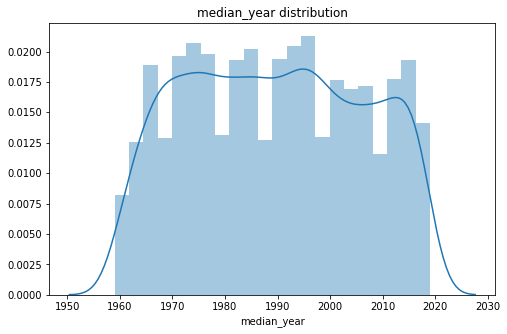

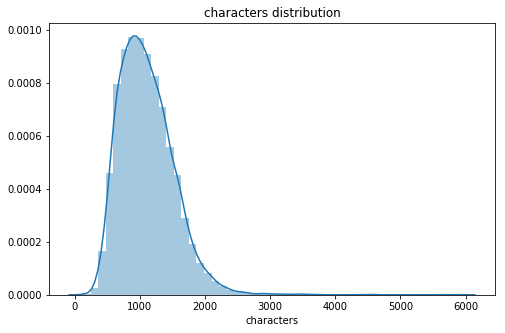

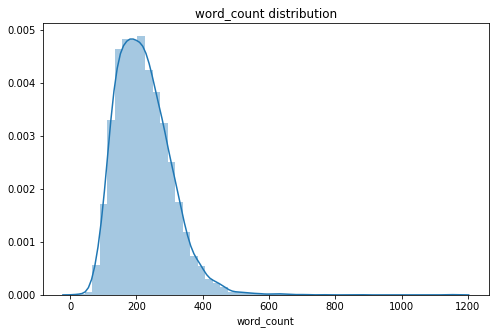

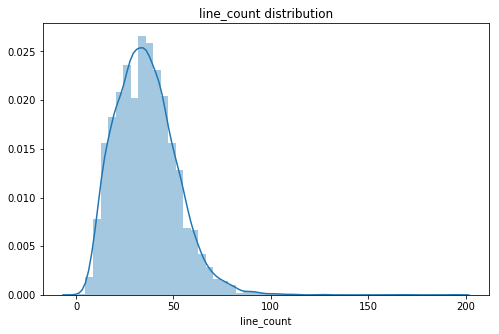

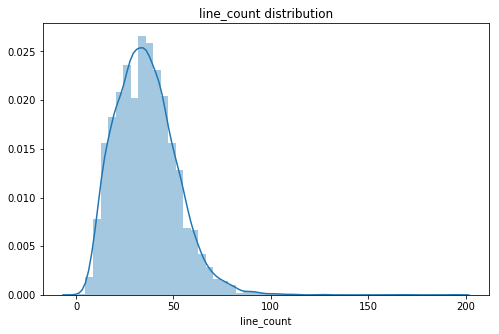

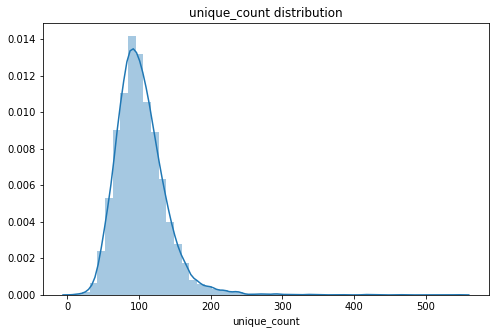

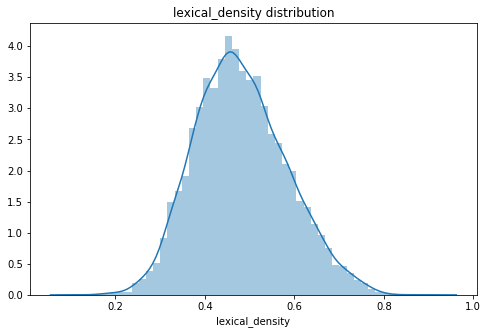

In [20]:
for feature in features:
    plot_distribution(lyrics_df,feature)

#### Lexical Density has Decreased Overall in Country Music:

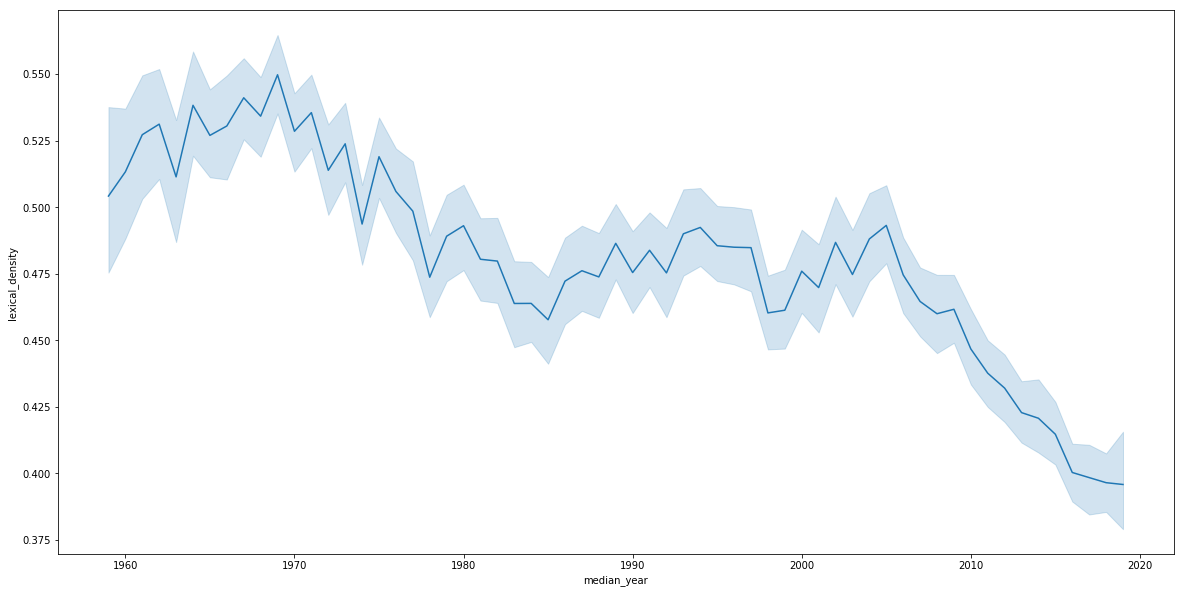

In [21]:
plt.figure(figsize = (20,10))
sns.lineplot(x = 'median_year',y = 'lexical_density',data = lyrics_df);

<a id='2a3'></a>

### __2b3. Process Song Lyrics__

In [22]:
# Function to tokenize lyrics

def tokenize(text):
    return [w for s in sent_tokenize(text) for w in word_tokenize(s)]

In [23]:
# Load stopwords from NLTK

stop_words = stopwords.words('english')

In [24]:
# Text cleaning pipeline:

def clean_text(text, ):
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in TweetTokenizer().tokenize(s)]
    def remove_punctuation(text):
        tokens = tokenize_text(text)
        tokens = [w for w in tokens if w.isalpha()]
        return ' '.join(tokens)
    def remove_stopwords(text):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    text = text.strip(' ') #remove whitespace
    text = text.lower() #lower case
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text

In [25]:
# Apply text cleaning functions to dataframe

lyrics_df['lyrics_processed'] = lyrics_df.loc[:,'lyrics'].apply(lambda x: clean_text(x))

In [26]:
lyrics_df.head()

,artist,lyrics,source,title,week_count,weeks,median_year,characters,word_count,line_count,unique_count,lexical_density,lyrics_processed
0,Alabama,Lyin' beside you watching you sleepin'\nAfter ...,wikilyrics,"""You've Got"" The Touch",15,"1987-04-26,1987-04-19,1987-04-12,1987-04-05,19...",1987,1204,252,49,84,0.333333,lyin beside watching sleepin loved tenderly se...
1,Billie Jo Spears,Come and look at this old faded photograph\nHo...,wikilyrics,'57 Chevrolet,9,"1978-10-15,1978-10-08,1978-10-01,1978-09-24,19...",1978,1122,232,33,106,0.456897,come look old faded photograph honey tell brin...
2,Wynn Stewart,\n\nA flower needs the earth to make it grow\n...,genius,'Cause I Have You,14,"1967-10-22,1967-10-15,1967-10-08,1967-10-01,19...",1967,540,117,19,68,0.581197,flower needs earth make grow river needs rains...
3,Clay Walker,"'Bout ten years old, hide and seek\nI found me...",wikilyrics,'Fore She Was Mama,25,"2007-03-18,2007-03-11,2007-03-04,2007-02-25,20...",2006,1448,280,52,160,0.571429,bout ten years old hide seek found closet read...
4,Sawyer Brown,Sue and Jack fell in love 'round here \nThey b...,wikilyrics,'Round Here,12,"1996-02-25,1996-02-18,1996-02-11,1996-02-04,19...",1996,1017,203,27,71,0.349754,sue jack fell love round goin steady years aff...


In [27]:
# Instantiate lemmatizer

lemmatizer = WordNetLemmatizer()

In [28]:
def lemmatize_text(text):
    text = [lemmatizer.lemmatize(w) for w in text.split(' ')]
    return ' '.join(text)

In [29]:
# Lemmatize lyrics:

lyrics_df['lyrics_processed'] = lyrics_df.loc[:,'lyrics_processed'].apply(lambda x: lemmatize_text(x))

In [30]:
lyrics_df.head()

,artist,lyrics,source,title,week_count,weeks,median_year,characters,word_count,line_count,unique_count,lexical_density,lyrics_processed
0,Alabama,Lyin' beside you watching you sleepin'\nAfter ...,wikilyrics,"""You've Got"" The Touch",15,"1987-04-26,1987-04-19,1987-04-12,1987-04-05,19...",1987,1204,252,49,84,0.333333,lyin beside watching sleepin loved tenderly se...
1,Billie Jo Spears,Come and look at this old faded photograph\nHo...,wikilyrics,'57 Chevrolet,9,"1978-10-15,1978-10-08,1978-10-01,1978-09-24,19...",1978,1122,232,33,106,0.456897,come look old faded photograph honey tell brin...
2,Wynn Stewart,\n\nA flower needs the earth to make it grow\n...,genius,'Cause I Have You,14,"1967-10-22,1967-10-15,1967-10-08,1967-10-01,19...",1967,540,117,19,68,0.581197,flower need earth make grow river need rain ma...
3,Clay Walker,"'Bout ten years old, hide and seek\nI found me...",wikilyrics,'Fore She Was Mama,25,"2007-03-18,2007-03-11,2007-03-04,2007-02-25,20...",2006,1448,280,52,160,0.571429,bout ten year old hide seek found closet ready...
4,Sawyer Brown,Sue and Jack fell in love 'round here \nThey b...,wikilyrics,'Round Here,12,"1996-02-25,1996-02-18,1996-02-11,1996-02-04,19...",1996,1017,203,27,71,0.349754,sue jack fell love round goin steady year affo...


In [31]:
# Save processed lyrics

lyrics_df.to_pickle(data_dir + 'lyrics_processed_df.pkl')